In [21]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset
import copy

In [2]:
dataset = load_dataset('cifar100', split='test')

Found cached dataset cifar100 (/Users/andrejerkelens/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)


In [3]:
def show_img(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [5]:
sample_image = dataset[1000]['img']

In [8]:
sample_label = dataset[1000]['fine_label']

In [9]:
sample_label

65

In [10]:
cv_image = np.array(sample_image)

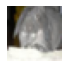

In [11]:
plt.figure(figsize=(1,1))
plt.imshow(cv_image)
plt.axis("off")
plt.show()

In [12]:
masks = mask_generator.generate(cv_image)

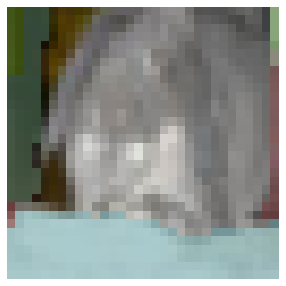

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(cv_image)
show_img(masks)
plt.axis('off')
plt.show() 

<b> Labels are currently wrong for tiny imagenet, though the predictions are correct (since they are in training set), I cannot currently find a mapping from tiny imagenet to regular imagenet so will have to assume the pred is correct </b>

<b> Q1: should i be using the OHE label or the logits? </b>

In [14]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, ViTImageProcessor

In [15]:
processor = ViTImageProcessor.from_pretrained("Ahmed9275/Vit-Cifar100")
classifier = AutoModelForImageClassification.from_pretrained("Ahmed9275/Vit-Cifar100")

inputs = processor(cv_image, return_tensors="pt")

with torch.no_grad():
    logits = classifier(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(classifier.config.id2label[predicted_label])

rabbit


In [16]:
cv_image.shape

(32, 32, 3)

### Calculate Shapley Interactions

In [17]:
height, width, channel = cv_image.shape

In [18]:
# logits
# logits.softmax(dim=-1)

In [19]:
pairs = []
for channel in range(channel):
    for i in range(width):
        for j in range(height):
            for k in range(i, width):
                for l in range(height):
                    if k == i and l <= j:
                        continue
                    pairs.append(((j,i,channel), (j,i,channel)))

In [22]:
# If we go pairwise within each channel
print(math.comb(32*32,2)*3)
# if we go pairwise across all channels
print(math.comb(3*32*32,2))
# We will modify on the raw image dim to reduce number of pairs, vs altering the processed inputs via VIT pretrained

1571328
4717056


In [23]:
assert len(pairs) == math.comb(height * width, 2) * 3

In [24]:
reference_value = 0 # Can change this to noise/avg/ some other reference value
cuda = False

def get_shapval(p1, p2, img, instruction:str):
    img1 = copy.deepcopy(img)

    if instruction == "a+b":
        pass
    elif instruction == "a":
        img1[p1] = reference_value
    elif instruction == "b":
        img1[p2] = reference_value
    elif instruction == "phi":
        img1[p1] = reference_value
        img1[p2] = reference_value

    inputs = processor(img1, return_tensors="pt")
        
    with torch.no_grad():
        logits = classifier(**inputs).logits

    return logits.softmax(dim=-1)


def get_interaction(pixel_pair, sample_image):

    p1, p2 = pixel_pair
    np_img = np.array(sample_image)

    phi = get_shapval(p1, p2, np_img, "phi")
    a = get_shapval(p1, p2, np_img, "a")
    b = get_shapval(p1, p2, np_img, "b")
    apb = get_shapval(p1, p2, np_img, "a+b")

    val = apb - a - b + phi
    
    if cuda:
        val = torch.linalg.norm(val, dim=-1).cpu()
    else:
        val = np.linalg.norm(val, axis=-1)
    
    return val

In [29]:
len(pairs)

1571328

In [ ]:
interactions = []
num_pairs = len(pairs)

for idx, pair in enumerate(pairs):
    if idx%100000==0:
        print(f"Complete: {idx}")
    interactions.append(get_interaction(pair, sample_image))

Complete: 0


---

### Calculate shapley residuals

### Ignore





In [37]:
from torch.nn import CrossEntropyLoss

In [38]:
X = cv_image.copy()

In [39]:
_c, _w, _h = torch.squeeze(inputs['pixel_values']).shape

In [40]:
N_dim = _c * _w * _h

### Calculate shapley residual for each pixel? or calculate shapley residual for each patch?

In [42]:
def generate_coalitions(N):
    # Does not account for empty coalition
    coalitions = []
    for i in range(1, 2 ** N):
        coalition = [j for j in range(N) if (i & (1 << j)) > 0]
        coalitions.append(tuple(coalition))
    return coalitions

In [182]:
# import numpy as np
# from scipy.optimize import minimize
# from itertools import combinations
# import math

# # Define value function v(S)
# def value_function(S, img, label):
#     temp_img = np.copy(img)
#     # Zero out the pixels not in S
#     # TODO: Decide if to 0 or add noises to pixels, may lead to different results, per https://arxiv.org/pdf/1704.02685.pdf
#     temp_img[0, list(S)] = 0  
#     inputs = processor(temp_img, return_tensors="pt")
#     with torch.no_grad():
#         logits = classifier(**inputs).logits
#     # prediction = logits.argmax(-1).item()
#     return CrossEntropyLoss()(logits, torch.tensor([label])).detach().numpy()

# def d_i_v(i, img):
#     S_with = set(range(img.shape[1])) - {i}
#     S_without = S_with
#     return value_function(S_with, img) - value_function(S_without, img)

# def d_v_i(v_i, i, img):
#     objective = lambda v: np.linalg.norm(d_i_v(i, img) - v)
#     res = minimize(objective, v_i, method="SLSQP")
#     return res.x[0]

# # Compute Shapley residual for an image
# def shapley_residual(img):
#     N = img.shape[1]
#     C,W,H  = torch.squeeze(processor(img, return_tensors="pt")["pixel_values"]).shape
    
#     shapley_residuals = np.zeros(C,W,H)
#     for c in range(C):
#         for w in range(W):
#             for h in range(H):
#                 v_i = 10  # set initial value?
#                 d_i = d_i_v(i, img)
#                 d_v = d_v_i(v_i, i, img)
#                 shapley_residuals[c][w][h] = d_i - d_v
#     return shapley_residuals

# # Example calculation for one image
# shapley_res = shapley_residual(cv_image)
# print(f"Shapley Residuals for the image: {shapley_res}")

TypeError: value_function() missing 1 required positional argument: 'label'

<br></br>
<br></br>
<br></br>

---
